# Medical Cost Prediction

This notebook focuses on predicting annual medical costs (`cost_claims_year`) using insurance and demographic features from a large dataset.

---

**Goal:** Build a regression model to accurately estimate medical costs based on features like age, gender, premium, and more.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

## Load Dataset

We load the dataset from the `Data` folder and preview its structure.


In [15]:
import pandas as pd

# Load your dataset
df = pd.read_csv("D:\Joy\Medical-Cost-Prediction-Smoking-Risk-Classification\Data\insurance.csv")  # adjust path/filename as needed

# Show columns and types
print(df.shape)
df.head()


(228711, 42)


,ID,ID_policy,ID_insured,period,date_effect_insured,date_lapse_insured,date_effect_policy,date_lapse_policy,year_effect_insured,year_lapse_insured,...,C_H,C_GI,C_II,C_IE_P,C_IE_S,C_IE_T,C_GE_P,C_GE_S,C_GE_T,C_C
0,1_1,1,1,2017,6/15/1993,12/20/2017,6/15/1993,NaN,1993,2017.0,...,H1,99.0,85.0,18.0,52.0,59.0,4.0,14.0,96.0,C6
1,1_2,1,2,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,H1,99.0,85.0,18.0,52.0,59.0,4.0,14.0,96.0,C6
2,2_1,2,1,2017,6/16/1993,NaN,6/16/1993,NaN,1993,NaN,...,H6,100.0,94.0,26.0,11.0,85.0,7.0,1.0,100.0,C6
3,3_3,3,3,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3_5,3,5,2017,6/15/1993,NaN,6/15/1993,NaN,1993,NaN,...,H6,99.0,81.0,32.0,34.0,69.0,9.0,4.0,98.0,C6


In [16]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228711 entries, 0 to 228710
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    228711 non-null  object 
 1   ID_policy             228711 non-null  int64  
 2   ID_insured            228711 non-null  int64  
 3   period                228711 non-null  int64  
 4   date_effect_insured   228711 non-null  object 
 5   date_lapse_insured    61530 non-null   object 
 6   date_effect_policy    228711 non-null  object 
 7   date_lapse_policy     54143 non-null   object 
 8   year_effect_insured   228711 non-null  int64  
 9   year_lapse_insured    61530 non-null   float64
 10  year_effect_policy    228711 non-null  int64  
 11  year_lapse_policy     54143 non-null   float64
 12  exposure_time         228711 non-null  float64
 13  lapse                 228711 non-null  int64  
 14  seniority_insured     228711 non-null  int64  
 15  

ID                           0
ID_policy                    0
ID_insured                   0
period                       0
date_effect_insured          0
date_lapse_insured      167181
date_effect_policy           0
date_lapse_policy       174568
year_effect_insured          0
year_lapse_insured      167181
year_effect_policy           0
year_lapse_policy       174568
exposure_time                0
lapse                        0
seniority_insured            0
seniority_policy             0
type_policy                  0
type_policy_dg               0
type_product                 0
reimbursement                0
new_business                 0
distribution_channel         0
gender                       0
age                          0
premium                      0
cost_claims_year             0
n_medical_services           0
n_insured_pc                 0
n_insured_mun                0
n_insured_prov               0
IICIMUN                  10886
IICIPROV                  5701
C_H     

## Select Relevant Features and Target

We will use the following columns:

- Target: `cost_claims_year`
- Features: `age`, `gender`, `premium`, `n_medical_services`, `distribution_channel`, `type_policy`, `type_product`, etc.

We will drop unnecessary columns like IDs.


In [17]:
selected_cols = [
    'age', 'gender', 'premium', 'n_medical_services',
    'distribution_channel', 'type_policy', 'type_product', 'cost_claims_year'
]
df = df[selected_cols].copy()

## Handle Missing Values

We will impute missing numerical values with the median and categorical values with the mode.


In [18]:
num_cols = ['age', 'premium', 'n_medical_services', 'cost_claims_year']
cat_cols = ['gender', 'distribution_channel', 'type_policy', 'type_product']

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

## Encode Categorical Variables

We convert categorical features into numeric codes using Label Encoding.


In [10]:
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df_sub[col] = le.fit_transform(df_sub[col])
    le_dict[col] = le  # Save encoder for potential inverse transform

df_sub.head()


,age,gender,premium,n_medical_services,distribution_channel,type_policy,type_product,cost_claims_year
0,83,1,2923.32,32,0,1,3,8242.62
1,80,0,1930.11,22,0,1,3,344.41
2,80,1,2020.00,24,0,1,2,523.18
3,88,0,1843.25,29,0,1,3,257.55
4,58,1,1316.03,9,0,1,3,420.16


## Split Dataset into Train and Test

We split data into 80% training and 20% testing sets.


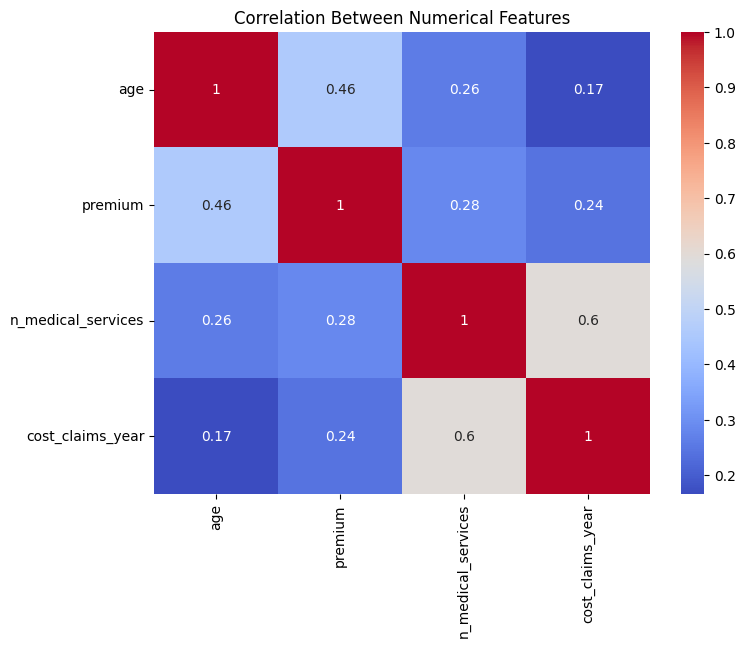

In [19]:
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Numerical Features")
plt.show()

## Train Regression Models

We will train:

- Linear Regression
- Random Forest Regressor


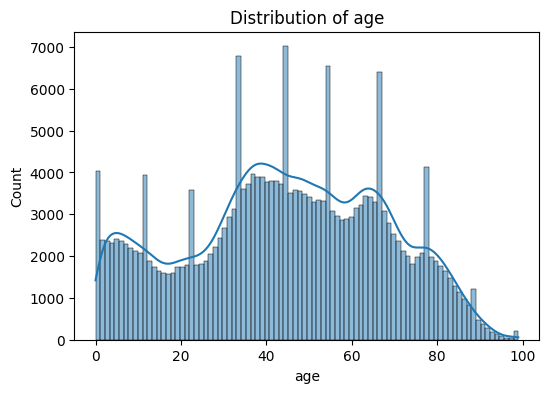

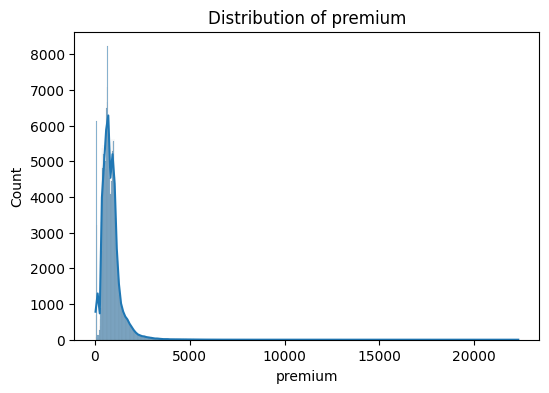

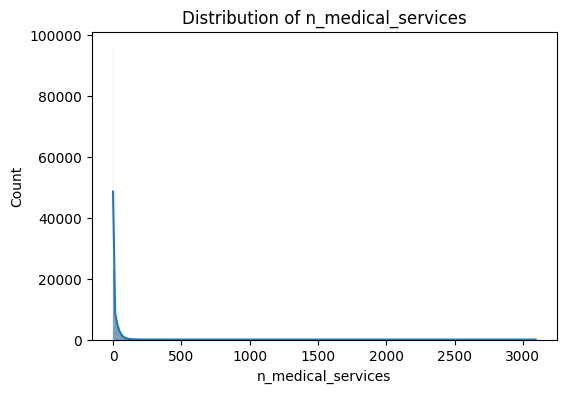

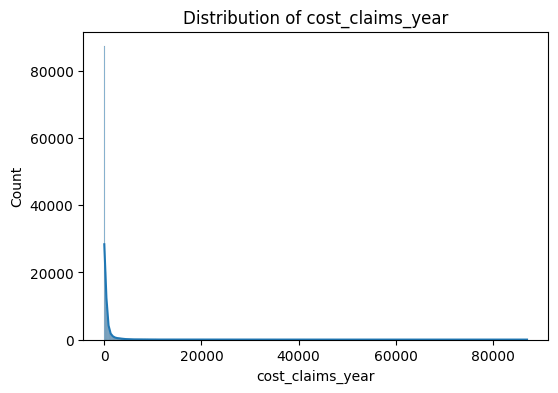

In [20]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

## Visualize Predictions vs Actual

We plot predicted vs actual costs to visually assess model performance.


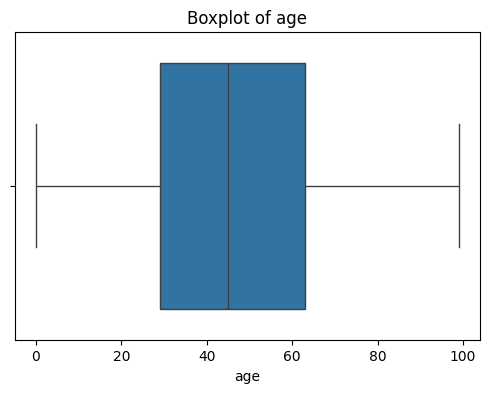

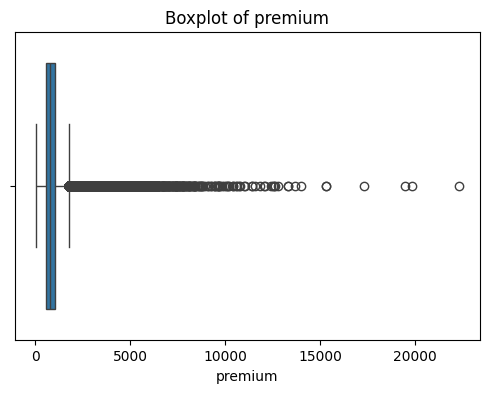

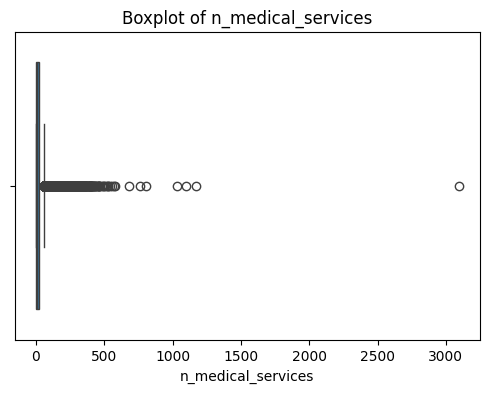

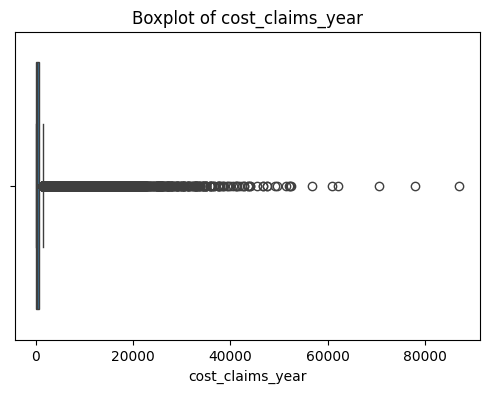

In [21]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [22]:
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['Young', 'Adult', 'Senior'])
df['premium_per_service'] = df['premium'] / (df['n_medical_services'] + 1)

In [23]:
encode_cols = ['gender', 'distribution_channel', 'type_policy', 'type_product', 'age_group']
le_dict = {}
for col in encode_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [24]:
X = df.drop('cost_claims_year', axis=1)
y = df['cost_claims_year']

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [28]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [29]:
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f" MAE: {mae:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" R2: {r2:.3f}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")


Linear Regression Results:
 MAE: 446.50
 RMSE: 1439.26
 R2: 0.285

Random Forest Results:
 MAE: 426.43
 RMSE: 1389.21
 R2: 0.334



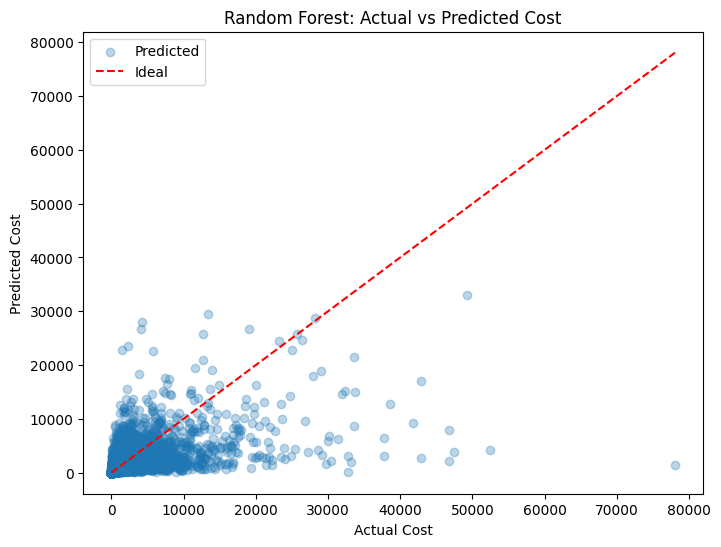

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Random Forest: Actual vs Predicted Cost")
plt.legend()
plt.show()
